In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import arviz as az
import pandas as p

import theano.tensor as tt
import theano

%matplotlib inline

In [ ]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]    
    return [ds, di]

times = np.arange(0,5,0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])


plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [ ]:
sir_model = DifferentialEquation(
    func=SIR, 
    times=np.arange(0.25, 5, 0.25), 
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:    
    sigma = pm.HalfCauchy('sigma', 1, shape=2)
    
    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)
    
    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])
    
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.5, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)
    
az.plot_posterior(data,round_to=2, credible_interval=0.95);

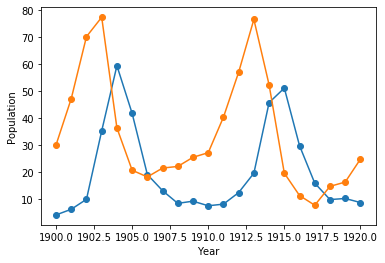

In [20]:
## Predator Prey Model

df = p.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T

plt.figure()
plt.plot(year,lynx,'-o')
plt.plot(year,hare,'-o')
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

In [18]:
def predator_prey(y,t,p):
    u,v = y[0], y[1]
    alpha, beta, gamma, delta = p[0], p[1], p[2], p[3]
    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v
    return [du_dt,dv_dt]

predator_prey_model = DifferentialEquation(
    func = predator_prey,
    times = times,
    n_states = 2,
    n_theta = 4,
    t0 = times[0]
)

with pm.Model() as model5:
    
    sigma = pm.Lognormal('sigma',mu=-1,sigma=1)
    alpha = pm.Normal('alpha',mu=1,sigma=0.5)
    gamma = pm.Normal('gamma',mu=1,sigma=0.5)
    beta = pm.Normal('beta',mu=0.05,sigma=0.05)
    delta = pm.Normal('delta',mu=0.05,sigma=0.05)
    
    # Note sure of this frame work can accept initial conditions from Bayesian distribution
    #u0 = pm.Lognormal('u0',np.log(10),1)
    #v0 = pm.Lognormal('v0',np.log(10),1)
    
    predator_prey_curves = predator_prey_model(y0=y[0,:],theta=[alpha,beta,gamma,delta])
    Y = pm.Lognormal('Y',mu=pm.math.log(predator_prey_curves),sd=sigma,observed=yobs)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(20,tune=100, target_accept=0.5, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)
    
az.plot_posterior(data,round_to=2, credible_interval=0.95);

y


NameError: name 'y' is not defined